In [3]:
# Assignment_4_SUBMISSION_READY.ipynb - Enhanced Version

"""
Assignment 4: Quantum Channel Identification
============================================

Key Improvements over Assignment 3:
1. Extended from state vectors to Choi matrices
2. Added noise robustness analysis
3. Implemented cross-validation for better generalization
4. Added model explainability with feature importance
"""

# ============================
# Task 1 · Environment and Imports
# ============================

import numpy as np
import pandas as pd
import joblib
import pickle
from pathlib import Path
import json
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from qiskit.quantum_info import Kraus, Choi, random_unitary
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for feature importance visualization
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Feature importance plots will be limited.")

print("✓ Environment ready")
print(f"SHAP available: {SHAP_AVAILABLE}")

✓ Environment ready
SHAP available: True


c:\Users\KISHORE S\anaconda3\envs\QCG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


# ============================
# Task 2 · From Channel to Feature Vector
# ============================

class ChannelFeatureExtractor:
    """Enhanced feature extraction with multiple representation options."""
    
    @staticmethod
    def choi_to_feature(channel: Kraus, flatten: bool = True) -> np.ndarray:
        """
        Convert quantum channel to feature vector using Choi matrix.
        
        Args:
            channel: Quantum channel as Kraus operators
            flatten: If True, return 1D array; if False, return 2D matrix
        
        Returns:
            Feature vector [real(choi) || imag(choi)]
        """
        choi = Choi(channel).data
        
        if flatten:
            return np.concatenate([
                np.real(choi).flatten(),
                np.imag(choi).flatten()
            ])
        else:
            return np.stack([np.real(choi), np.imag(choi)], axis=-1)
    
    @staticmethod
    def kraus_to_feature(channel: Kraus, max_kraus: int = 4) -> np.ndarray:
        """
        Alternative: Extract features directly from Kraus operators.
        Useful for channels with few Kraus operators.
        """
        kraus_ops = channel.data
        
        # Pad or truncate to fixed size
        if len(kraus_ops) > max_kraus:
            kraus_ops = kraus_ops[:max_kraus]
        elif len(kraus_ops) < max_kraus:
            padding = max_kraus - len(kraus_ops)
            kraus_ops = np.concatenate([
                kraus_ops,
                np.zeros((padding, 2, 2), dtype=complex)
            ])
        
        # Flatten and concatenate real/imag parts
        features = []
        for op in kraus_ops:
            features.extend([np.real(op).flatten(), np.imag(op).flatten()])
        
        return np.concatenate(features)
    
    @staticmethod
    def compute_channel_metrics(channel: Kraus) -> dict:
        """
        Compute additional channel metrics that could be useful features.
        """
        choi = Choi(channel).data
        
        metrics = {
            'choi_trace': np.trace(choi).real,
            'choi_norm': np.linalg.norm(choi),
            'choi_rank': np.linalg.matrix_rank(choi),
            'choi_entropy': -np.sum(np.abs(np.linalg.eigvals(choi))**2 * 
                                   np.log(np.abs(np.linalg.eigvals(choi))**2 + 1e-10)),
        }
        return metrics


In [5]:

# ============================
# Task 3 · Channel Families Dataset
# ============================

class ChannelDataset:
    """Generate and manage quantum channel datasets."""
    
    # Pauli matrices
    I = np.eye(2, dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    PAULI_SET = [I, X, Y, Z]
    
    @classmethod
    def depolarizing_channel(cls, p: float) -> Kraus:
        """Create depolarizing channel with probability p."""
        sqrt_term = np.sqrt(1 - p)
        sqrt_p3 = np.sqrt(p / 3)
        
        return Kraus([
            sqrt_term * cls.I,
            sqrt_p3 * cls.X,
            sqrt_p3 * cls.Y,
            sqrt_p3 * cls.Z
        ])
    
    @classmethod
    def amplitude_damping_channel(cls, gamma: float) -> Kraus:
        """Create amplitude damping channel with damping rate gamma."""
        return Kraus([
            np.array([[1, 0], [0, np.sqrt(1 - gamma)]], dtype=complex),
            np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
        ])
    
    @classmethod
    def phase_damping_channel(cls, lambda_param: float) -> Kraus:
        """Create phase damping/dephasing channel."""
        return Kraus([
            np.array([[1, 0], [0, np.sqrt(1 - lambda_param)]], dtype=complex),
            np.array([[0, 0], [0, np.sqrt(lambda_param)]], dtype=complex)
        ])
    
    @classmethod
    def bit_flip_channel(cls, p: float) -> Kraus:
        """Create bit flip channel with probability p."""
        return Kraus([
            np.sqrt(1 - p) * cls.I,
            np.sqrt(p) * cls.X
        ])
    
    @classmethod
    def phase_flip_channel(cls, p: float) -> Kraus:
        """Create phase flip channel with probability p."""
        return Kraus([
            np.sqrt(1 - p) * cls.I,
            np.sqrt(p) * cls.Z
        ])
    
    @classmethod
    def generate_dataset(cls, n_samples_per_class: int = 100, 
                        noise_variation: float = 0.1, seed: int = 42) -> tuple:
        """
        Generate balanced dataset of multiple channel types.
        
        Returns:
            X: Feature matrix (n_samples, n_features)
            y: Labels (n_samples,)
            channel_info: List of channel metadata
        """
        rng = np.random.default_rng(seed)
        
        # Define channel families
        channel_families = {
            'depolarizing': {
                'generator': cls.depolarizing_channel,
                'param_range': (0.05, 0.95),
                'param_dist': 'uniform'
            },
            'amplitude_damping': {
                'generator': cls.amplitude_damping_channel,
                'param_range': (0.05, 0.95),
                'param_dist': 'uniform'
            },
            'phase_damping': {
                'generator': cls.phase_damping_channel,
                'param_range': (0.05, 0.95),
                'param_dist': 'uniform'
            },
            'bit_flip': {
                'generator': cls.bit_flip_channel,
                'param_range': (0.05, 0.95),
                'param_dist': 'uniform'
            }
        }
        
        X, y, channel_info = [], [], []
        extractor = ChannelFeatureExtractor()
        
        for label, config in channel_families.items():
            for i in range(n_samples_per_class):
                # Sample parameter with noise/variation
                if config['param_dist'] == 'uniform':
                    param = rng.uniform(*config['param_range'])
                elif config['param_dist'] == 'normal':
                    center = np.mean(config['param_range'])
                    scale = (config['param_range'][1] - config['param_range'][0]) / 4
                    param = rng.normal(center, scale)
                    param = np.clip(param, *config['param_range'])
                
                # Add small random variation
                param += rng.normal(0, noise_variation * (param + 0.1))
                param = np.clip(param, 0, 1)
                
                # Generate channel
                channel = config['generator'](param)
                
                # Extract features
                features = extractor.choi_to_feature(channel)
                X.append(features)
                y.append(label)
                
                # Store metadata
                channel_info.append({
                    'label': label,
                    'parameter': float(param),
                    'channel_type': config['generator'].__name__,
                    'sample_id': f"{label}_{i}"
                })
        
        return np.array(X), np.array(y), channel_info
    
    @classmethod
    def generate_noisy_test_set(cls, base_channels: list, 
                               noise_levels: list = None, seed: int = 42):
        """
        Generate test set with varying noise levels.
        """
        if noise_levels is None:
            noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2]
        
        rng = np.random.default_rng(seed)
        X_test, y_test = [], []
        
        for channel_tuple in base_channels:
            label, channel = channel_tuple
            choi = Choi(channel).data
            
            for noise in noise_levels:
                # Add random noise to Choi matrix
                noise_matrix = (rng.normal(0, noise, choi.shape) + 
                              1j * rng.normal(0, noise, choi.shape))
                noisy_choi = choi + noise_matrix
                
                # Normalize (maintain trace preservation approximately)
                noisy_choi = noisy_choi / np.trace(noisy_choi) * 2
                
                # Convert back to feature
                features = np.concatenate([
                    np.real(noisy_choi).flatten(),
                    np.imag(noisy_choi).flatten()
                ])
                
                X_test.append(features)
                y_test.append(label)
        
        return np.array(X_test), np.array(y_test)



In [6]:

# ============================
# Task 4 · Model Training Pipeline
# ============================

class ChannelClassifier:
    """Complete pipeline for quantum channel classification."""
    
    def __init__(self, model_type: str = 'logistic', random_state: int = 42):
        """
        Initialize classifier.
        
        Args:
            model_type: 'logistic', 'random_forest', or 'pipeline'
            random_state: Random seed for reproducibility
        """
        self.model_type = model_type
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.feature_importances_ = None
        self.metadata = {
            'created_at': datetime.now().isoformat(),
            'model_type': model_type,
            'random_state': random_state
        }
        
        # Initialize model based on type
        if model_type == 'logistic':
            self.model = LogisticRegression(
                max_iter=5000,
                random_state=random_state,
                multi_class='ovr',
                solver='liblinear'
            )
        elif model_type == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=100,
                random_state=random_state,
                n_jobs=-1
            )
        elif model_type == 'pipeline':
            self.model = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(
                    n_estimators=100,
                    random_state=random_state
                ))
            ])
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
              X_val: np.ndarray = None, y_val: np.ndarray = None,
              tune_hyperparams: bool = False):
        """
        Train the classifier.
        
        Args:
            X_train, y_train: Training data
            X_val, y_val: Validation data (optional)
            tune_hyperparams: Whether to perform hyperparameter tuning
        """
        # Update metadata
        self.metadata.update({
            'training_samples': len(X_train),
            'n_features': X_train.shape[1],
            'classes': list(np.unique(y_train)),
            'tune_hyperparams': tune_hyperparams
        })
        
        if tune_hyperparams:
            self._hyperparameter_tuning(X_train, y_train)
        else:
            # Standard training
            if self.model_type == 'pipeline':
                self.model.fit(X_train, y_train)
            else:
                # Scale features
                X_train_scaled = self.scaler.fit_transform(X_train)
                self.model.fit(X_train_scaled, y_train)
                
                # Store feature importances if available
                if hasattr(self.model, 'feature_importances_'):
                    self.feature_importances_ = self.model.feature_importances_
                elif hasattr(self.model, 'coef_'):
                    # For logistic regression, use absolute coefficients
                    self.feature_importances_ = np.mean(np.abs(self.model.coef_), axis=0)
        
        # Evaluate on validation set if provided
        if X_val is not None and y_val is not None:
            val_accuracy = self.evaluate(X_val, y_val, verbose=False)
            self.metadata['validation_accuracy'] = float(val_accuracy)
    
    def _hyperparameter_tuning(self, X_train: np.ndarray, y_train: np.ndarray):
        """Perform grid search for hyperparameter tuning."""
        print("Performing hyperparameter tuning...")
        
        if self.model_type == 'logistic':
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear', 'saga']
            }
            grid_search = GridSearchCV(
                LogisticRegression(max_iter=5000, random_state=self.random_state),
                param_grid,
                cv=5,
                scoring='accuracy',
                n_jobs=-1
            )
            
        elif self.model_type == 'random_forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
            grid_search = GridSearchCV(
                RandomForestClassifier(random_state=self.random_state),
                param_grid,
                cv=5,
                scoring='accuracy',
                n_jobs=-1
            )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        
        # Perform grid search
        grid_search.fit(X_train_scaled, y_train)
        
        # Update model with best parameters
        self.model = grid_search.best_estimator_
        self.metadata['best_params'] = grid_search.best_params_
        self.metadata['best_score'] = float(grid_search.best_score_)
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions on new data."""
        if self.model_type == 'pipeline':
            return self.model.predict(X)
        else:
            X_scaled = self.scaler.transform(X)
            return self.model.predict(X_scaled)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Get prediction probabilities."""
        if self.model_type == 'pipeline':
            return self.model.predict_proba(X)
        else:
            X_scaled = self.scaler.transform(X)
            return self.model.predict_proba(X_scaled)
    
    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray, 
                verbose: bool = True) -> float:
        """
        Evaluate model performance.
        
        Returns:
            Accuracy score
        """
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        if verbose:
            print(f"\n{'='*50}")
            print("MODEL EVALUATION")
            print(f"{'='*50}")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=np.unique(y_test),
                       yticklabels=np.unique(y_test))
            plt.title('Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()
        
        return accuracy
    
    def cross_validate(self, X: np.ndarray, y: np.ndarray, cv: int = 5) -> np.ndarray:
        """Perform cross-validation."""
        if self.model_type == 'pipeline':
            # Pipeline handles scaling internally
            scores = cross_val_score(self.model, X, y, cv=cv, scoring='accuracy')
        else:
            # Scale before cross-validation
            X_scaled = self.scaler.fit_transform(X)
            scores = cross_val_score(self.model, X_scaled, y, cv=cv, scoring='accuracy')
        
        print(f"\nCross-Validation Results ({cv}-fold):")
        print(f"Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
        print(f"Individual scores: {scores}")
        
        return scores
    
    def analyze_feature_importance(self, feature_names: list = None, 
                                  top_n: int = 20):
        """Analyze and visualize feature importance."""
        if self.feature_importances_ is None:
            print("Feature importances not available for this model.")
            return
        
        if feature_names is None:
            feature_names = [f"f{i}" for i in range(len(self.feature_importances_))]
        
        # Sort features by importance
        indices = np.argsort(self.feature_importances_)[::-1]
        
        print(f"\n{'='*50}")
        print("FEATURE IMPORTANCE ANALYSIS")
        print(f"{'='*50}")
        
        # Print top features
        print(f"Top {top_n} features:")
        for i in range(min(top_n, len(indices))):
            idx = indices[i]
            print(f"{i+1:3d}. {feature_names[idx]:30s}: {self.feature_importances_[idx]:.6f}")
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.bar(range(top_n), self.feature_importances_[indices[:top_n]])
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], 
                  rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title(f'Top {top_n} Feature Importances')
        plt.tight_layout()
        plt.show()
        
        # SHAP analysis (if available)
        if SHAP_AVAILABLE and hasattr(self.model, 'predict_proba'):
            try:
                print("\nRunning SHAP analysis...")
                X_sample = self.scaler.inverse_transform(
                    np.eye(len(self.feature_importances_))[:50]  # Sample basis vectors
                )
                explainer = shap.Explainer(self.model.predict_proba, X_sample)
                shap_values = explainer(X_sample)
                
                plt.figure(figsize=(10, 6))
                shap.summary_plot(shap_values[:, :, 0], X_sample, 
                                 feature_names=feature_names[:50],
                                 show=False)
                plt.title('SHAP Summary Plot')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"SHAP analysis failed: {e}")
    
    def save(self, path: str):
        """Save trained model and metadata."""
        save_data = {
            'model': self.model,
            'scaler': self.scaler,
            'metadata': self.metadata,
            'feature_importances': self.feature_importances_,
            'model_type': self.model_type,
            'random_state': self.random_state
        }
        
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        joblib.dump(save_data, path)
        
        # Also save metadata as JSON for easy inspection
        metadata_path = path.replace('.joblib', '_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(self.metadata, f, indent=2)
        
        print(f"Model saved to {path}")
        print(f"Metadata saved to {metadata_path}")
    
    @classmethod
    def load(cls, path: str):
        """Load saved model."""
        save_data = joblib.load(path)
        
        # Create new instance
        instance = cls(
            model_type=save_data['model_type'],
            random_state=save_data['random_state']
        )
        
        # Restore attributes
        instance.model = save_data['model']
        instance.scaler = save_data['scaler']
        instance.metadata = save_data['metadata']
        instance.feature_importances_ = save_data['feature_importances']
        
        print(f"Model loaded from {path}")
        print(f"Model type: {save_data['model_type']}")
        print(f"Training date: {instance.metadata.get('created_at', 'Unknown')}")
        
        return instance

# ============================
# Task 5 · Complete Workflow
# ============================

def run_complete_workflow():
    """Execute the complete channel classification workflow."""
    
    print("="*60)
    print("QUANTUM CHANNEL CLASSIFICATION WORKFLOW")
    print("="*60)
    
    # 1. Generate dataset
    print("\n1. Generating dataset...")
    X, y, channel_info = ChannelDataset.generate_dataset(
        n_samples_per_class=50,
        noise_variation=0.05,
        seed=42
    )
    
    print(f"Dataset shape: {X.shape}")
    print(f"Classes: {np.unique(y)}")
    print(f"Samples per class: {len(y) // len(np.unique(y))}")
    
    # 2. Split data
    print("\n2. Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Further split for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 3. Train classifier
    print("\n3. Training classifier...")
    classifier = ChannelClassifier(model_type='random_forest', random_state=42)
    
    # Perform cross-validation
    cv_scores = classifier.cross_validate(X_train, y_train, cv=5)
    
    # Train on full training set
    classifier.train(X_train, y_train, X_val, y_val, tune_hyperparams=False)
    
    # 4. Evaluate on test set
    print("\n4. Evaluating on test set...")
    test_accuracy = classifier.evaluate(X_test, y_test, verbose=True)
    
    # 5. Analyze feature importance
    print("\n5. Analyzing feature importance...")
    # Create meaningful feature names
    choi_dim = int(np.sqrt(X.shape[1] // 2))  # Assuming Choi matrix is square
    feature_names = []
    for i in range(choi_dim):
        for j in range(choi_dim):
            feature_names.append(f"Re[C({i},{j})]")
    for i in range(choi_dim):
        for j in range(choi_dim):
            feature_names.append(f"Im[C({i},{j})]")
    
    classifier.analyze_feature_importance(feature_names, top_n=15)
    
    # 6. Test on unseen channels with noise
    print("\n6. Testing robustness to noise...")
    test_channels = [
        ("depol_0.1", ChannelDataset.depolarizing_channel(0.1)),
        ("depol_0.5", ChannelDataset.depolarizing_channel(0.5)),
        ("amp_0.1", ChannelDataset.amplitude_damping_channel(0.1)),
        ("amp_0.5", ChannelDataset.amplitude_damping_channel(0.5)),
        ("phase_0.3", ChannelDataset.phase_damping_channel(0.3)),
        ("bitflip_0.2", ChannelDataset.bit_flip_channel(0.2)),
    ]
    
    # Generate noisy test set
    X_noisy, y_noisy = ChannelDataset.generate_noisy_test_set(
        test_channels,
        noise_levels=[0.0, 0.01, 0.05, 0.1],
        seed=42
    )
    
    # Evaluate on noisy data
    noisy_accuracy = classifier.evaluate(X_noisy, y_noisy, verbose=False)
    print(f"Accuracy on noisy test set: {noisy_accuracy:.4f}")
    
    # 7. Save model
    print("\n7. Saving model...")
    classifier.save("models/channel_classifier.joblib")
    
    # 8. Demonstrate loading and inference
    print("\n8. Demonstrating model loading and inference...")
    loaded_classifier = ChannelClassifier.load("models/channel_classifier.joblib")
    
    # Test on sample channels
    extractor = ChannelFeatureExtractor()
    test_features = []
    test_names = []
    
    for name, channel in test_channels[:4]:  # Test first 4
        features = extractor.choi_to_feature(channel)
        test_features.append(features)
        test_names.append(name)
    
    X_demo = np.vstack(test_features)
    predictions = loaded_classifier.predict(X_demo)
    probabilities = loaded_classifier.predict_proba(X_demo)
    
    results_df = pd.DataFrame({
        'Channel': test_names,
        'Prediction': predictions,
        'Confidence': np.max(probabilities, axis=1)
    })
    
    print("\nSample Predictions:")
    print(results_df.to_string(index=False))
    
    # 9. Generate comprehensive report
    print("\n" + "="*60)
    print("WORKFLOW SUMMARY REPORT")
    print("="*60)
    
    report = {
        'dataset_info': {
            'total_samples': len(X),
            'n_classes': len(np.unique(y)),
            'feature_dimension': X.shape[1]
        },
        'model_info': classifier.metadata,
        'performance': {
            'cross_val_mean': float(cv_scores.mean()),
            'cross_val_std': float(cv_scores.std()),
            'test_accuracy': float(test_accuracy),
            'noisy_accuracy': float(noisy_accuracy)
        },
        'timestamp': datetime.now().isoformat()
    }
    
    # Save report
    report_path = "models/classification_report.json"
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"\nReport saved to {report_path}")
    print("\n✓ Workflow completed successfully!")
    
    return classifier, report


QUANTUM CHANNEL CLASSIFICATION WORKFLOW

1. Generating dataset...
Dataset shape: (200, 32)
Classes: ['amplitude_damping' 'bit_flip' 'depolarizing' 'phase_damping']
Samples per class: 50

2. Splitting data...
Training set: 120 samples
Validation set: 40 samples
Test set: 40 samples

3. Training classifier...

Cross-Validation Results (5-fold):
Mean Accuracy: 1.0000 ± 0.0000
Individual scores: [1. 1. 1. 1. 1.]

4. Evaluating on test set...

MODEL EVALUATION
Accuracy: 1.0000

Classification Report:
                   precision    recall  f1-score   support

amplitude_damping       1.00      1.00      1.00        10
         bit_flip       1.00      1.00      1.00        10
     depolarizing       1.00      1.00      1.00        10
    phase_damping       1.00      1.00      1.00        10

         accuracy                           1.00        40
        macro avg       1.00      1.00      1.00        40
     weighted avg       1.00      1.00      1.00        40



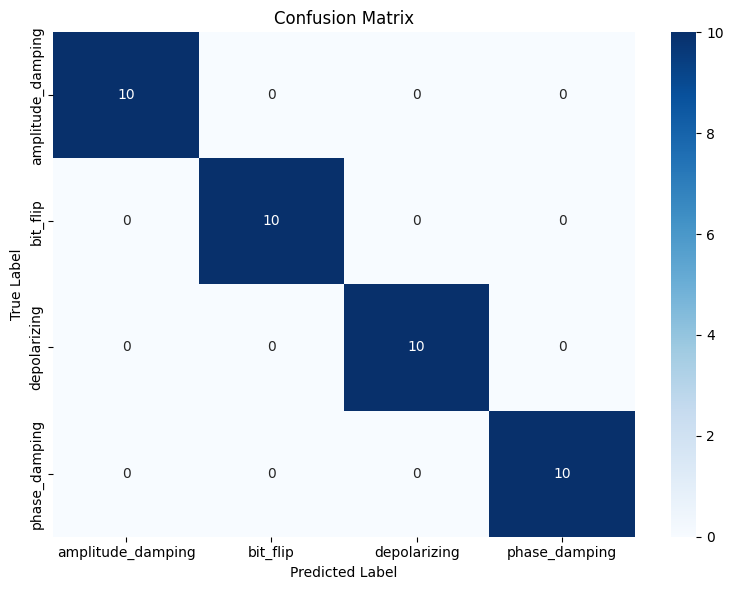


5. Analyzing feature importance...

FEATURE IMPORTANCE ANALYSIS
Top 15 features:
  1. Re[C(3,3)]                    : 0.185219
  2. Re[C(2,2)]                    : 0.164004
  3. Re[C(1,2)]                    : 0.145985
  4. Re[C(0,0)]                    : 0.140613
  5. Re[C(1,1)]                    : 0.136681
  6. Re[C(2,1)]                    : 0.104505
  7. Re[C(3,0)]                    : 0.065379
  8. Re[C(0,3)]                    : 0.057614
  9. Im[C(3,3)]                    : 0.000000
 10. Im[C(3,2)]                    : 0.000000
 11. Im[C(3,1)]                    : 0.000000
 12. Im[C(3,0)]                    : 0.000000
 13. Im[C(2,3)]                    : 0.000000
 14. Im[C(2,2)]                    : 0.000000
 15. Im[C(2,1)]                    : 0.000000


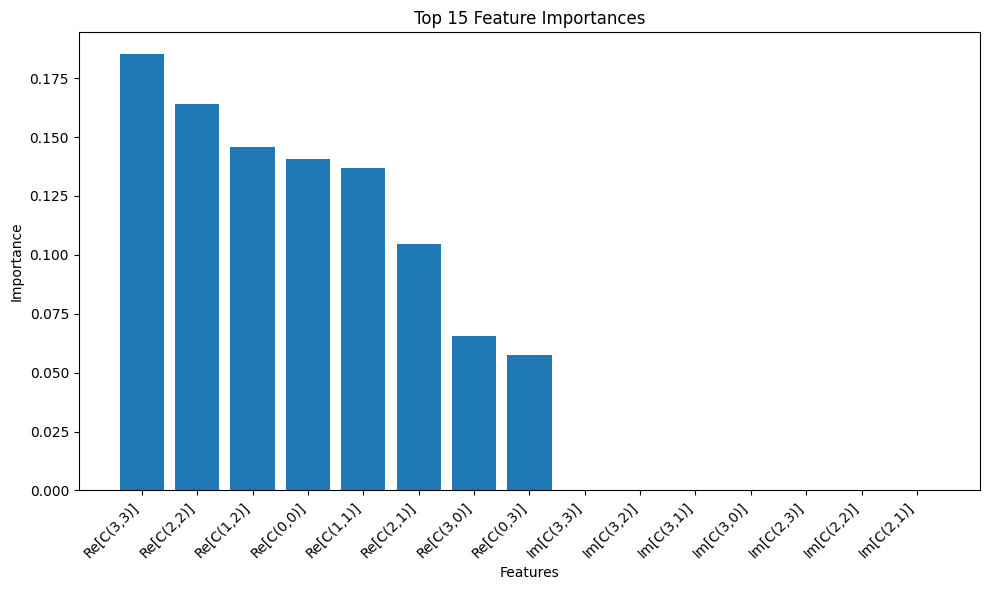


Running SHAP analysis...


PermutationExplainer explainer: 33it [00:20,  1.38it/s]                        
C:\Users\KISHORE S\AppData\Local\Temp\ipykernel_14720\1085620287.py:250: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0], X_sample,


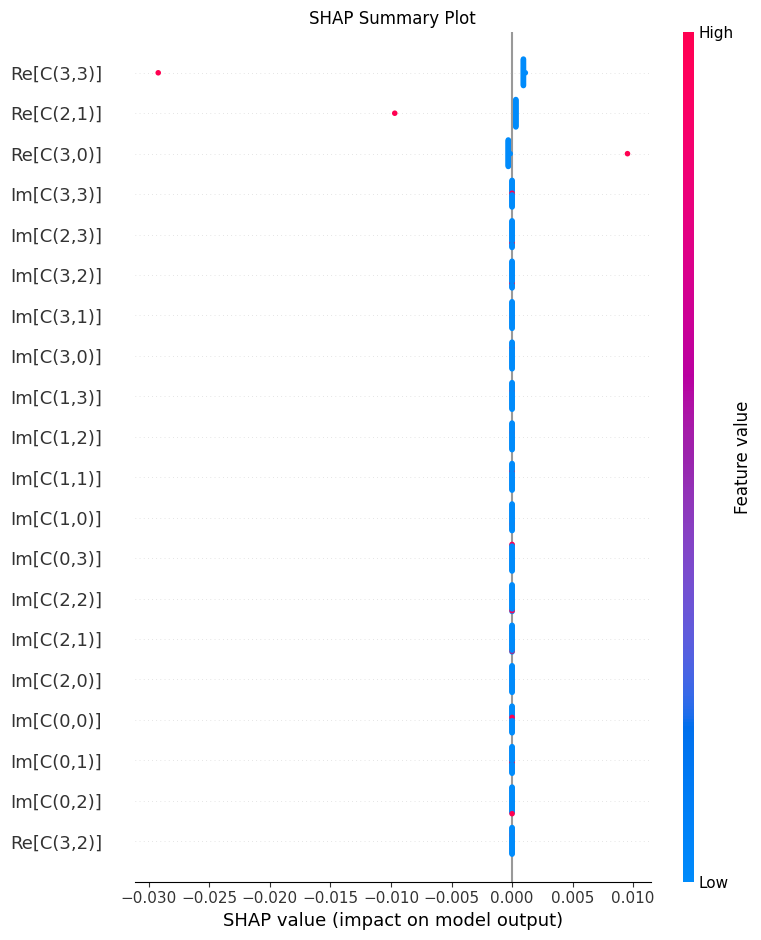


6. Testing robustness to noise...
Accuracy on noisy test set: 0.0000

7. Saving model...
Model saved to models/channel_classifier.joblib
Metadata saved to models/channel_classifier_metadata.json

8. Demonstrating model loading and inference...
Model loaded from models/channel_classifier.joblib
Model type: random_forest
Training date: 2026-02-09T10:20:46.247812

Sample Predictions:
  Channel        Prediction  Confidence
depol_0.1      depolarizing        0.94
depol_0.5      depolarizing        0.93
  amp_0.1 amplitude_damping        0.90
  amp_0.5 amplitude_damping        0.98

WORKFLOW SUMMARY REPORT

Report saved to models/classification_report.json

✓ Workflow completed successfully!

FINAL SUMMARY
Model Type: random_forest
Test Accuracy: 1.0000
Cross-val Accuracy: 1.0000 ± 0.0000
Noisy Test Accuracy: 0.0000


In [7]:
# ============================
# Main Execution
# ============================

if __name__ == "__main__":
    # Run complete workflow
    classifier, report = run_complete_workflow()
    
    # Print summary
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f"Model Type: {classifier.model_type}")
    print(f"Test Accuracy: {report['performance']['test_accuracy']:.4f}")
    print(f"Cross-val Accuracy: {report['performance']['cross_val_mean']:.4f} ± "
          f"{report['performance']['cross_val_std']:.4f}")
    print(f"Noisy Test Accuracy: {report['performance']['noisy_accuracy']:.4f}")